# Proyek Pertama: Predictive Analytics Saham Tesla (2010-2023)
Pendahuluan
Penjelasan Proyek: Notebook ini bertujuan untuk memprediksi harga saham Tesla (2010-2023) menggunakan teknik Predictive Analytics berbasis model Long Short-Term Memory (LSTM). Model ini dirancang untuk memanfaatkan data historis harga saham guna memprediksi harga di masa depan.

Data set: https://www.kaggle.com/datasets/muhammadbilalhaneef/-tesla-stock-price-from-2010-to-2023?resource=download

## 1. Import Library


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings

warnings.filterwarnings('ignore')

## 2. Load Dataset


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Adri720S/PredictiveAnalytics1_Saham-Tesla-2010-2023-/refs/heads/main/Tesla%20Stock%20Price%20(2010%20to%202023).csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,29/06/2010,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,30/06/2010,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,01/07/2010,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,02/07/2010,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,06/07/2010,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


## 3. Data Understanding


#### a. Dimensi Dataset: "Memeriksa jumlah baris dan kolom dalam dataset menggunakan properti .shape."

In [3]:
# Dimensi dataset
print(f"Dataset memiliki {df.shape[0]} baris dan {df.shape[1]} kolom.")

Dataset memiliki 3162 baris dan 7 kolom.


#### b. Tipe Data: "Informasi tentang tipe data tiap kolom diperiksa menggunakan df.info() untuk memastikan kompatibilitas dengan analisis selanjutnya."


In [4]:
# Informasi tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3162 entries, 0 to 3161
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3162 non-null   object 
 1   Open       3162 non-null   float64
 2   High       3162 non-null   float64
 3   Low        3162 non-null   float64
 4   Close      3162 non-null   float64
 5   Adj Close  3162 non-null   float64
 6   Volume     3162 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 173.1+ KB


#### c. Penanganan Missing Values
Penanganan missing value dengan metode forward fill untuk mengisi nilai yang hilang agar data tetap konsisten.

In [5]:
# Mengecek missing values
print("Jumlah missing values:")
print(df.isnull().sum())

# Mengisi missing values dengan metode forward fill
df.fillna(method='ffill', inplace=True)

Jumlah missing values:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


#### d. Duplicate Data

In [6]:
# Mengecek duplikasi
duplicates = df.duplicated().sum()
print(f"Terdapat {duplicates} data duplikat.")

# Jika ada, menghapus duplikasi
df = df.drop_duplicates()

Terdapat 0 data duplikat.


#### e. Statistik Deskriptif: "Melakukan ringkasan statistik numerik menggunakan .describe() untuk melihat distribusi data.

In [7]:
# Statistik deskriptif
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3.162000e+03
mean,59.090024,60.415403,57.622371,59.039845,59.039845,9.394769e+07
std,95.550672,97.746213,93.067484,95.420232,95.420232,8.175154e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,9.037333,9.252500,8.828500,9.066833,9.066833,4.243012e+07
50%,16.294334,16.514666,16.016334,16.295666,16.295666,7.609725e+07
75%,24.965833,25.212667,24.438666,24.986833,24.986833,1.179720e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


#### f. Mendeteksi outlier


Jumlah Outlier pada kolom Open: 706

Jumlah Outlier pada kolom High: 717

Jumlah Outlier pada kolom Low: 704

Jumlah Outlier pada kolom Close: 711

Jumlah Outlier pada kolom Adj Close: 711

Jumlah Outlier pada kolom Volume: 204


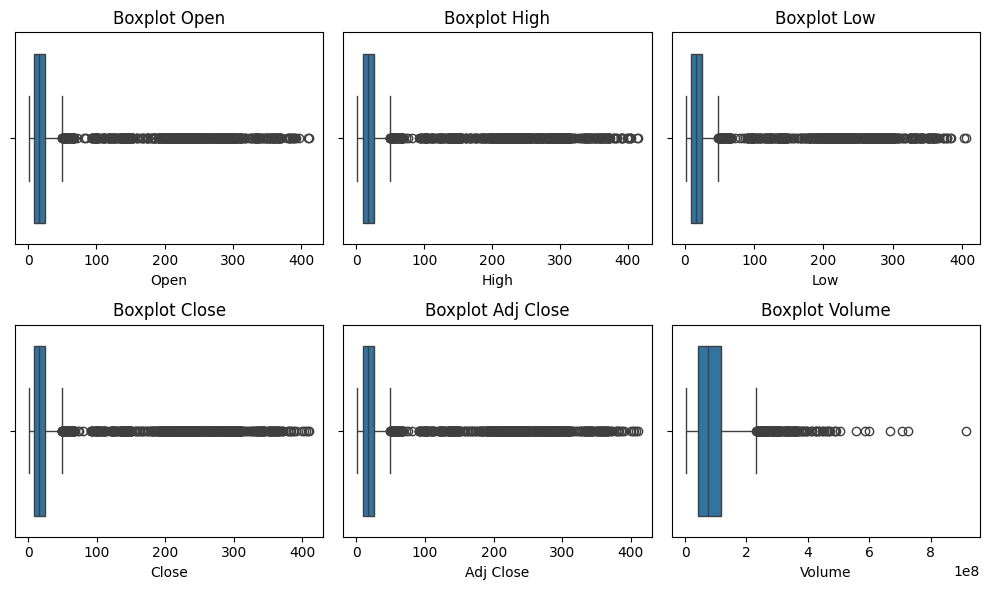

In [8]:
# Deteksi Outlier menggunakan IQR
def detect_outliers_iqr(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Deteksi outlier untuk semua kolom numerik
numerical_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in numerical_cols:
    outliers = detect_outliers_iqr(col)
    print(f"\nJumlah Outlier pada kolom {col}: {len(outliers)}")

# Visualisasi distribusi dan outlier
plt.figure(figsize=(10, 6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot {col}")
plt.tight_layout()
plt.show()

Informasi kondisi dataset tidak ada missing value, tidak ada data duplikat dan outlier merupakan nilai dari pergerakan saham tersebut.

## 4. Data Preparation

#### a. Ubah kolom Date ke Format Datetime

In [11]:
# Mengubah kolom Date menjadi datetime
df['Date'] = pd.to_datetime(df['Date'])
# Informasi tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3162 entries, 0 to 3161
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3162 non-null   datetime64[ns]
 1   Open       3162 non-null   float64       
 2   High       3162 non-null   float64       
 3   Low        3162 non-null   float64       
 4   Close      3162 non-null   float64       
 5   Adj Close  3162 non-null   float64       
 6   Volume     3162 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 173.1 KB


#### b. Normalisasi Data
Kolom Close dinormalisasi menggunakan MinMaxScaler agar nilainya berada dalam rentang 0-1. Bertujuan untuk meningkatkan performa model yang sensitif terhadap skala data.

In [13]:
# Normalisasi data kolom Close
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

# Menampilkan data yang telah dinormalisasi
scaled_data[:5]

array([[1.31893376e-03],
       [1.30915182e-03],
       [1.00428041e-03],
       [5.54310983e-04],
       [5.05408598e-05]])

#### c. Split Data
Dataset dibagi menjadi subset training (80%) dan testing (20%).

In [14]:
data = df[['Close']]
scaled_data = scaler.fit_transform(data)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

#### d. Membuat Sequence Data
Membuat sequence data dengan panjang 60 untuk digunakan sebagai input model LSTM. Maka model akan menggunakan data harga penutupan 60 hari terakhir untuk memprediksi harga pada hari berikutnya.

In [15]:
# Fungsi untuk membuat sequence data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Parameter panjang sequence
seq_length = 60

# Membuat sequence data
X, y = create_sequences(scaled_data, seq_length)

# Melihat dimensi data hasil sequence
print(f"Dimensi X: {X.shape}, Dimensi y: {y.shape}")

Dimensi X: (3102, 60), Dimensi y: (3102,)


#### e. Visualisasi Data
Pergerakan harga penutupan saham Tesla divisualisasikan menggunakan line plot. Agar gambaran umum tentang pola harga saham selama periode waktu tertentu dapat terlihat.

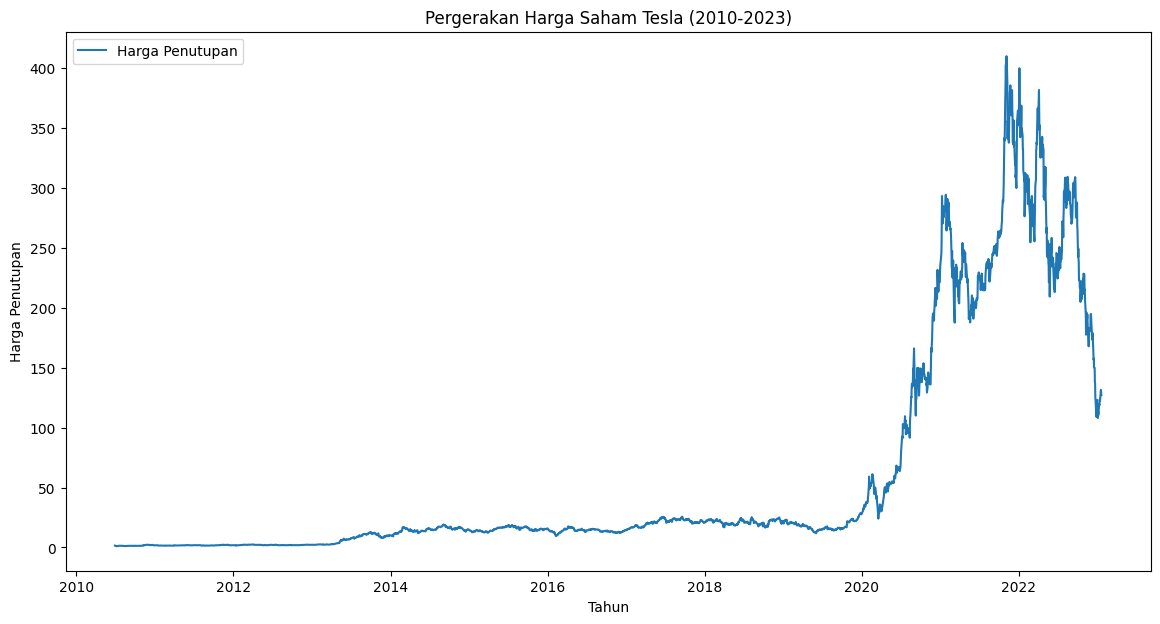

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Harga Penutupan')
plt.title('Pergerakan Harga Saham Tesla (2010-2023)')
plt.xlabel('Tahun')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.show()

## 5. Preprocessing Data


#### Membuat Sequence untuk Training dan Testing


In [17]:
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = X_train.reshape(-1, seq_length, 1)
X_test = X_test.reshape(-1, seq_length, 1)

## 6. Bangun Model LSTM
Membangun model LSTM menggunakan Sequential dari tensorflow.keras. Menggunakan dua lapisan LSTM dengan lapisan dropout untuk mencegah overfitting, serta dua lapisan Dense untuk menghasilkan output akhir berupa prediksi harga.

In [18]:
# Bangun model LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Latih model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 6.9634e-04 - val_loss: 0.0112
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 5.3886e-05 - val_loss: 0.0072
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 4.3305e-05 - val_loss: 0.0225
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 3.8778e-05 - val_loss: 0.0031
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 4.9243e-05 - val_loss: 0.0308
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 4.3874e-05 - val_loss: 0.0203
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 1.9410e-05 - val_loss: 0.0180
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 3.0001e-05 - val_loss: 0.0348
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 2.4171e-05 - val_loss: 0.0340
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 2.3036e-05 - val_loss: 0.0341
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 2.4423e-05 - val_loss: 0.0235
Epoch 12/50
78/78 

## 7. Evaluasi dan Prediksi

In [19]:
# Prediksi menggunakan data testing
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Balikkan skala ke bentuk asli

# Balikkan skala y_test ke bentuk asli
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluasi dengan RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Root Mean Squared Error (RMSE): 14.992601553476236


## 8. Visualisasi Hasil
Hasil prediksi dibandingkan dengan harga aktual menggunakan grafik untuk melihat sejauh mana model mampu mengikuti pola harga saham.

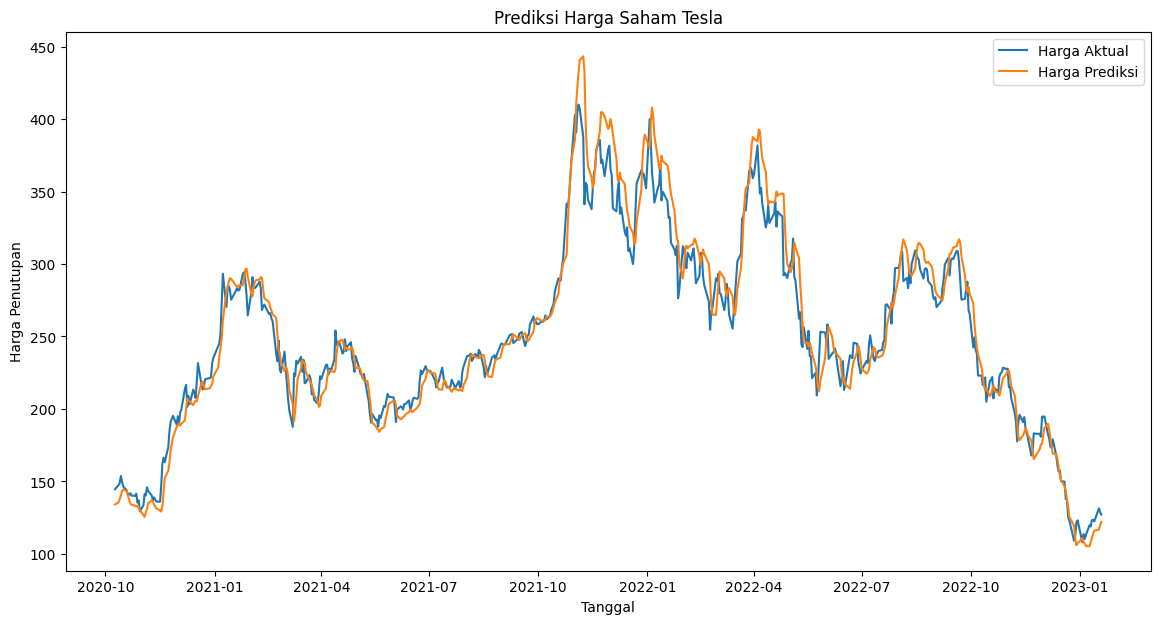

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'][-len(y_test):], y_test_actual, label='Harga Aktual')
plt.plot(df['Date'][-len(y_test):], predictions, label='Harga Prediksi')
plt.title('Prediksi Harga Saham Tesla')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.show()